In [1]:
# !pip install python-igraph
# !pip install pycairo

In [2]:
import igraph as ig
from igraph import plot
import pandas as pd
import numpy as np
from threading import Timer
from timeit import default_timer as timer
from IPython.display import clear_output
import itertools
import time
import csv

In [10]:
# Python3 program to print Vertex Cover
# of a given undirected graph
from collections import defaultdict


# This class represents a directed graph
# using adjacency list representation
class Graph:

    def __init__(self, dataset, method=None):
        self.cover = []
        # Default dictionary to store graph
        self.graph = defaultdict(list)
        if method is None:
            self.addEdgePear(dataset)
        elif method == 'ma':
            self.addEdgeMA(dataset)
        
        
        # Function to add an edge to graph by adjacency matrix
    def addEdgeMA(self,dataset):      
        for i in np.arange(dataset.shape[1]):
            v = 'v'+str(i+1)   
            l=0
            for j in dataset[v]:
                if(j==1 and i!=l):
                    self.graph[i].append(l)
                l+=1
    # Function to add an edge to graph pear-to-pear          
    def addEdgePear(self, dataset):
        nodes = np.array([dataset.ni,dataset.nj])
        for i in np.arange(len(nodes[0])):
            self.graph[nodes[0][i]].append(nodes[1][i])
        #Exibe o gráfico no formato gráfico
        
    def graph_plot(self,x_box, y_box, color, layout_type):
        # Instância Graph
        G = ig.Graph()

        # Separando chaves do dicionário
#         print(self.graph)
        graph_keys = list(self.graph.keys())
        # Adicionando n vértices no grafo
        G.add_vertices(len(graph_keys))

        # Encontrando índices das arestas e as adicionando no grafo
        graph_edges = []

        for i, key in enumerate(graph_keys):
            for j in self.graph[key]:
                if j in graph_keys:
                    if not (graph_keys.index(j), i) in graph_edges:
                        graph_edges.append((i, graph_keys.index(j)))

        G.add_edges(graph_edges)

        # Plotagem do grafo
        box = (x_box, y_box)
        layout = G.layout(layout_type) # circle, drl, fr, kk, large, random, rt, rt_circular
        colors = [color] * len(graph_keys)
        return plot(G, layout=layout, bbox = box, vertex_label=graph_keys, vertex_color=colors)
    
    
    
class VerticeCover:
    def __init__(self):
        self.cover = []
        
        #Buss' algorithm T(n-k) + n
    def buss(self, G, k):
        print('k: ',k,'new Graph \n:',len(G),' nós e ',len(self.getEdge(G)),' vertices')
        
        isolateds = self.isolatedsVertices(G)
        if(k==0 and len(isolateds)==len(G)):
            return True
        elif(k==0 and len(isolateds)!=len(G)):
            return False
        
        H = self.getSubH(G,k)
        print('número de vértices maiores que k: ',len(H))
        if(len(H)>0):
            if len(H)>k:
                return False
            else:
                print('Subtraindo H de G')
                G,k2 = self.GlessH(G,H,k)
                if(len(G)>(k*k2)):
                    return False
                
                if self.noTrivial(G) > k:
                    return False
            
            return self.buss(G,k2)
        else:
            print('Calculando por força bruta')
            return self.bruteForce(G, k)

    
    #function get no trivial nodes
    def noTrivial(self, G):
        cont = 0
        for u in range(len(G)):
            if(len(G[u])>=2):
                cont +=1
        return cont
    

    
    #function to remove some node and its incidences
    def removeNode(self, G, key):
        for i in G:
            if key in G[i]:
                G[i].remove(key)
        iso = self.isolatedsVertices(G)
        for j in iso:
            G.pop(j,None)
        G.pop(key,None)
        return G
    
    #function to remove subset H of G Theta(n)
    def GlessH(self, G, H, k):
        for p in H:
            print('Removendo o nó: ',p)
            G = self.removeNode(G, p)
            k = k - len(H)
        isolateds = self.isolatedsVertices(G)
        for i in isolateds:
            print('Removendo nó isolado: ',i)
            G = self.removeNode(G, i)
        return [G,k]
    
        #function to get sub set deg(V)>k Theta(n)
    def getSubH(self, G, k):
        iso = []
        for u in range(len(G)):
            if(len(G[u])>k):
                iso.append(u)
        return iso
    
        #function to get isolated vertices Theta(n)
    def isolatedsVertices(self, G):
        iso = []
        for u in range(len(G)):
            if(len(G[u])==0):
                iso.append(u)
        return iso
    
        #function to get edges not repeated Theta(n^2)
    def getEdge(self, graph):
        edges = set()
        for u in graph:
            for v in graph[u]:
                e = str(u)+str(v)
                if e not in edges and e[::-1] not in edges:
                    edges.add(e)
        return list(edges)
    
    

        
   
        
    #function convert proposed cover in sub set graph
    def sugGraph(self, G, nodes):
        H = defaultdict(list)
        for v in nodes:
            H[v] = G[v]
        return H
    

    #function to check a valid cover
    def check_cover(self,G, H):
        visited = False*len(G) 
        for i in G:
            if i not in H and i[::-1] not in H:
                return False
        return True
    
    #function to answare by brute force vertice cover
    def bruteForce(self, G,k):
        cont=0
        for i in itertools.combinations(G,k):
            cont +=1
            print('Analisando possibilidade :',cont)
            print(i)
            G2 = self.getEdge(G)
            H = self.getEdge(self.sugGraph(G,i))
            
            if(self.check_cover(G2,H)==True):
                return True
            print('O conjunto proposto não é uma cobertura')
        print('Número de possibilidades a serem analisadas: ',cont)
        return False
    

        
    #function to return some valid cover from graph to some k
    def getValidCover(self, G,k):
        for i in itertools.combinations(G,k):
            G2 = self.getEdge(G)
            H = self.getEdge(self.sugGraph(G,i))
            if(self.check_cover(G2,H)==True):
                self.cover = i
                return i
        return 'Não existe cobertura para k='+str(k)

    def timeCount(self, start):
        diff = time.time()-start  
        if(diff<1):
            return str(round(diff*1000,2))+ ' ms'
        else:
            return time.strftime('%H:%M:%S', time.gmtime(diff))
            
    def saveFile(self, results, name='Experiment_results'):
        cols = ['k', 'duration', 'buss_response']
        MyLIst = []
        for x in results:
            MyLIst.append([x,results[x][1],results[x][0]])
            
        df_result= pd.DataFrame(MyLIst, columns = cols)
        print('saving: ',name, '......')
        f = open(name,'a')
        try:
            writer = csv.writer(f)
#             writer.writerow(df_result.columns)
            for i in np.arange(int(df_result.shape[0])):
                writer.writerow(df_result.iloc[i,])
        finally:
            f.close()

    
        
        
    


# Exemplo de Explicação de funcionamento do algoritmo

In [19]:
dataset = pd.read_csv('exemples/ex2.csv')
dataset.index = dataset.columns
print(dataset)
g = Graph(dataset, 'ma')



    v1  v2  v3  v4  v5  v6
v1   1   1   0   0   1   0
v2   1   0   1   0   1   0
v3   0   1   0   1   0   0
v4   0   0   1   0   1   1
v5   1   1   0   1   0   0
v6   0   0   0   1   0   0


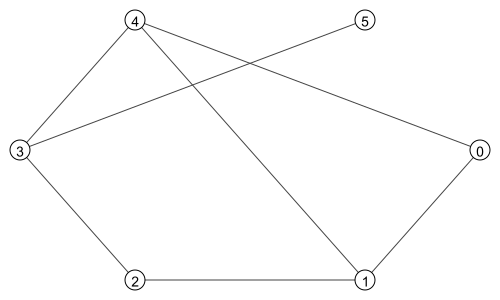

In [20]:
g.graph_plot(500, 300, 'white', 'circle')

In [25]:
k=4
vg = VerticeCover()
vg.buss(g.graph,k)


k:  4 new Graph 
: 6  nós e  7  vertices
número de vértices maiores que k:  0
Calculando por força bruta
Analisando possibilidade : 1
(0, 1, 2, 3)


True

In [26]:
g = Graph(dataset, 'ma')

vg = VerticeCover()
vg.getValidCover(g.graph,k)

(0, 1, 2, 3)

# Experimento 1 (Dataset information - Gnutella peer-to-peer network, August 4 2002. Disponível em: https://snap.stanford.edu/data/p2p-Gnutella04.html) 

# Directed graph (each unordered pair of nodes is saved once): 
# p2p-Gnutella04.txt 
# Directed Gnutella P2P network from August 4 2002
# Nodes: 10876 Edges: 39994
# Used Nodes: 4859 Used Edges: 39427
# FromNodeId	ToNodeId

In [27]:
dataset2 = pd.read_csv('experiments/exp1.csv')
g2 = Graph(dataset2)
vg = VerticeCover()
print('Quantidade de Nós: ',len(g2.graph.keys()))
print('Quantidade de vértices: ',len(vg.getEdge(g2.graph)))
# print('Grafo: ',g2.graph)

Quantidade de Nós:  4859
Quantidade de vértices:  39427


In [11]:
# experiments=[1,2,3,4,5,6,7,8,9,10,15,20]
# experiments = [25]
# experiments = [30]
# experiments = [35,40,45]
# experiments = [40,45,50,55,60,70,80,100]


results = defaultdict(list)
for k in range(100,len(g2.graph)):
    vg = VerticeCover()
    dataset2 = pd.read_csv('experiments/exp1.csv')
    g = Graph(dataset2)
    print('Analisando k=',k,'...')
    start = time.time()    
    results[k].append(vg.buss(g.graph,k))
    results[k].append(vg.timeCount(start))
    
    print('k:',k, 'instance: ',results[k])
    vg.saveFile(results)



Analisando k= 100 ...
k:  100 new Graph 
: 4859  nós e  39427  vertices
número de vértices maiores que k:  0
Calculando por força bruta
Analisando possibilidade : 1
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 190)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 2
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 13

O conjunto proposto não é uma cobertura
Analisando possibilidade : 17
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 229)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 18
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 1

O conjunto proposto não é uma cobertura
Analisando possibilidade : 35
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 256)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 36
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 1

O conjunto proposto não é uma cobertura
Analisando possibilidade : 52
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 281)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 53
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 1

O conjunto proposto não é uma cobertura
Analisando possibilidade : 73
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 327)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 74
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 1

O conjunto proposto não é uma cobertura
Analisando possibilidade : 92
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 358)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 93
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 1

O conjunto proposto não é uma cobertura
Analisando possibilidade : 108
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 411)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 109
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

O conjunto proposto não é uma cobertura
Analisando possibilidade : 129
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 458)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 130
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

O conjunto proposto não é uma cobertura
Analisando possibilidade : 145
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 487)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 146
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

O conjunto proposto não é uma cobertura
Analisando possibilidade : 161
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 524)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 162
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

O conjunto proposto não é uma cobertura
Analisando possibilidade : 179
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 565)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 180
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

O conjunto proposto não é uma cobertura
Analisando possibilidade : 196
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 592)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 197
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

O conjunto proposto não é uma cobertura
Analisando possibilidade : 214
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 631)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 215
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

O conjunto proposto não é uma cobertura
Analisando possibilidade : 231
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 660)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 232
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

O conjunto proposto não é uma cobertura
Analisando possibilidade : 249
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 692)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 250
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

O conjunto proposto não é uma cobertura
Analisando possibilidade : 266
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 716)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 267
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

O conjunto proposto não é uma cobertura
Analisando possibilidade : 287
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 758)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 288
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

O conjunto proposto não é uma cobertura
Analisando possibilidade : 306
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 807)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 307
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

O conjunto proposto não é uma cobertura
Analisando possibilidade : 323
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 839)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 324
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

O conjunto proposto não é uma cobertura
Analisando possibilidade : 342
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176, 177, 180, 181, 183, 184, 185, 187, 189, 866)
O conjunto proposto não é uma cobertura
Analisando possibilidade : 343
(0, 1, 3, 8, 10, 12, 14, 17, 19, 20, 21, 23, 25, 26, 29, 30, 38, 39, 46, 54, 58, 60, 61, 62, 65, 73, 75, 76, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 101, 106, 107, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 141, 144, 147, 148, 150, 153, 154, 157, 158, 162, 165, 166, 167, 168, 170, 171, 175, 176,

KeyboardInterrupt: 